Security Analystics - Final Project 
=====
--------
## Detecting Web-based Attacks via Machine Learning
-------------------------------
## Authors: Chenfeng Nie, Shuaichen Wu, Xiaoyi Rao
## Johns Hopkins Information Security Insititude
## Date: 12/16/2017



 * **Experiment Environment**:
        1. python 3+
        2. jupyter notebook
 * **Tools**:
        1. numpy
        2. sklearn
        3. scipy
        4. pandas
        5. matplotlib
        6. seaborn
        7. python 3+
 * **Procedure**:
        1. Collect datasets in both legit usage and malicious usage
        2. Data Preprocessing and Data Analyze
        3. Apply KNN algorithm
        4. Apply SVM algorithm
        5. Apply Tdidf algorithm
        6. Conclusion

In [1]:
# Import the libraries we will be using
import os
import math
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.spatial import distance

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 14, 8

# I've abstracted some of what we'll be doing today into a library.
# You can take a look at this code if you want by going into `dstools/data_tools.py`
from dstools import data_tools

np.random.seed(36)

import urllib.parse
#For python 2 version
#from urlparse import urlparse
from collections import Counter

c:\program files\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#pandas version
pd.__version__

'0.21.0'

In [3]:
# method entropy is used to calculate entropy value for each query
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [4]:

#use pandas data frame for pretty print
normal_usage = pd.read_csv('normal.txt', sep='\t', names=[ "queries"])
df_normal = pd.DataFrame(normal_usage)
df_normal.insert(0, 'label', '0')

#convert original queries to unicode mode
df_normal['unicode'] = df_normal['queries'].str.encode('utf-8')

# add length feature
df_normal['length'] = df_normal['queries'].astype('str').apply(len)
# add entropy feature
df_normal['entropy'] = df_normal['unicode'].map(lambda x: entropy(x))
#summary statistics on normal usage dataset
df_normal.count()


label      24781
queries    24781
unicode    24781
length     24781
entropy    24781
dtype: int64

In [5]:
#show variance of normal usage dataset
df_normal.var()

length     145.646872
entropy      0.309801
dtype: float64

In [6]:
# show df_normal last 5 rows to make sure data is loaded
df_normal.tail()

,label,queries,unicode,length,entropy
24776,0,/ezdetach/,b'/ezdetach/',10,2.921928
24777,0,/fmoffice-small/,b'/fmoffice-small/',16,3.327820
24778,0,/fantastic four v1 001-100 complete/,b'/fantastic four v1 001-100 complete/',36,4.127987
24779,0,/euphoria/,b'/euphoria/',10,3.121928
24780,0,/includes/xhtml.php?d_root=http://192.168.202....,b'/includes/xhtml.php?d_root=http://192.168.20...,70,4.800801


In [7]:

#use pandas's datagram for better print
malicious_usage = pd.read_csv('malicious.txt', sep='\t', names=[ "queries"])
df_malicious = pd.DataFrame(malicious_usage)
df_malicious.insert(0, 'label', '1')

#convert original queries to 8-bit unicode mode
df_malicious['unicode'] = df_malicious['queries'].str.encode('utf-8')

#add length feature
df_malicious['length'] = df_malicious['queries'].astype('str').apply(len)
#add entropy feature
df_malicious['entropy'] = df_malicious['unicode'].map(lambda x: entropy(x))
#summary statistics on malicious dataset
df_malicious.describe()


,length,entropy
count,6961.000000,6961.000000
mean,64.735957,3.873172
std,98.894505,0.992576
min,1.000000,-0.000000
25%,24.000000,3.136864
50%,48.000000,4.201924
75%,75.000000,4.648956
max,3033.000000,5.892698


In [8]:
#show variance of malicious dataset
df_malicious.var()

length     9780.123088
entropy       0.985206
dtype: float64

In [9]:
#show last 5 rows to make sure data is loaded
df_malicious.tail()

,label,queries,unicode,length,entropy
6956,1,"<XML SRC=""http://ha.ckers.org/xsstest.xml"" ID=...","b'<XML SRC=""http://ha.ckers.org/xsstest.xml"" I...",106,4.955310
6957,1,"'';!--""<XSS>=&{()}","b'\'\';!--""<XSS>=&{()}'",18,3.836592
6958,1,Execute(MsgBox(chr(88)&chr(83)&chr(83)))<,b'Execute(MsgBox(chr(88)&chr(83)&chr(83)))<',41,3.973916
6959,1,document.__parent__._=alert,b'document.__parent__._=alert',27,3.676391
6960,1,top.__proto__._= alert,b'top.__proto__._= alert',22,3.226731


# Note: 
   * **0** stands for normal usage
   * **1** stands for malicious attacks
      
### we notice that the malicious queries or payloads always have different characteristics 

In [10]:
#combine two data frames
data=pd.concat([df_malicious, df_normal],ignore_index=True)
# show statistics 
data.groupby('label').describe()
print (len(data))

31742


In [11]:
#find which query has the largest length and print it
#data['length'].idxmax()
print(data.iloc[215])

label                                                      1
queries    <a href="javascript&colon;\u0061&#x6C;&#101%72...
unicode    b'<a href="javascript&colon;\\u0061&#x6C;&#101...
length                                                    70
entropy                                              4.82795
Name: 215, dtype: object


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000198428269E8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000019842AD64A8>], dtype=object)

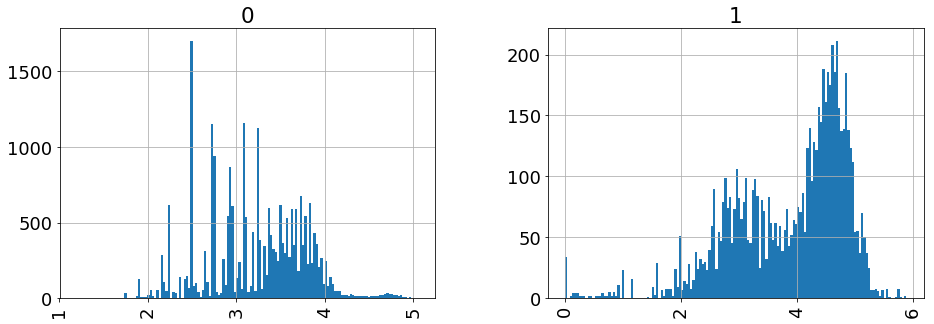

In [12]:
#plot length
# set default figure and font size
%matplotlib inline
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = 15, 5
plt.rcParams['axes.grid'] = True
#plt.ylim[(0,4000)]

#plot historical diagrams by entropy and length
data.hist( column='entropy', by= 'label', bins=150)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019842B2C358>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001984312E278>], dtype=object)

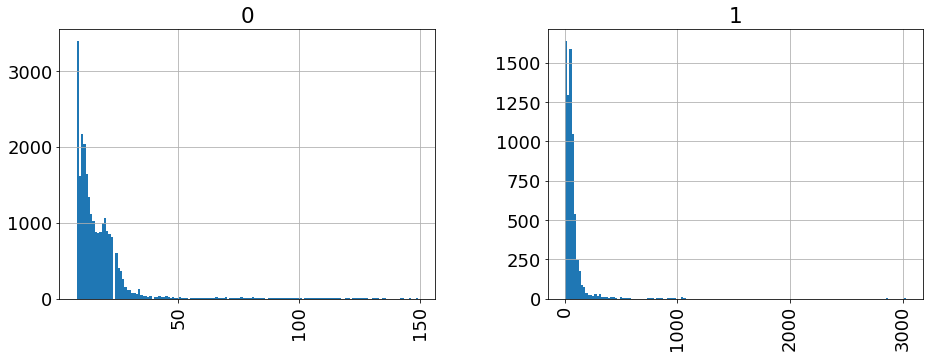

In [13]:
data.hist(column='length', by= 'label', bins=150)

Text(0,0.5,'Statement Entropy')

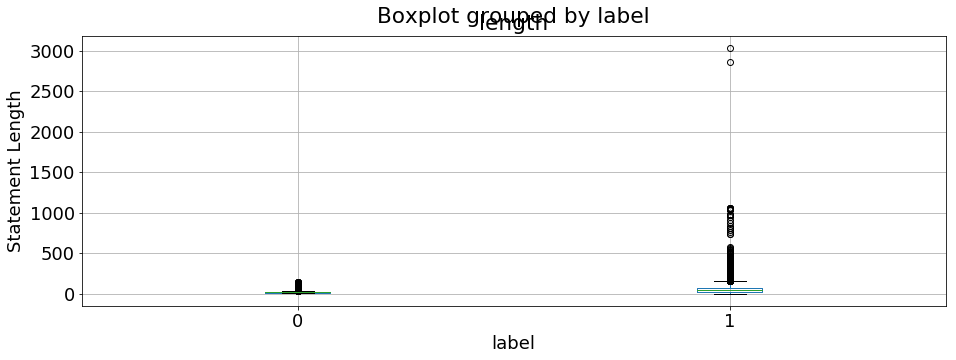

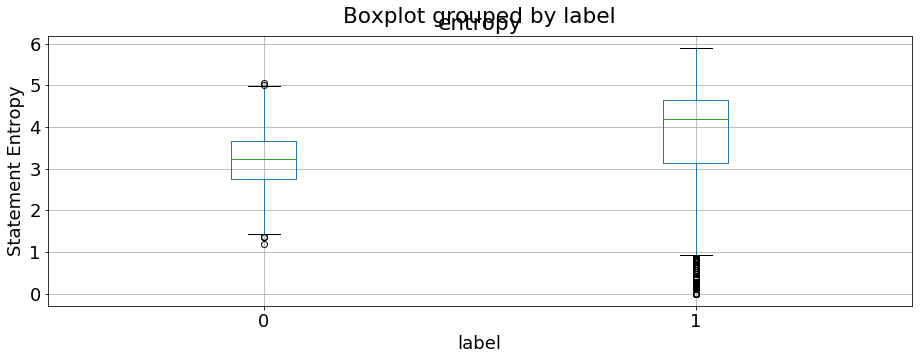

In [14]:

# Boxplots show you the distribution of the data (spread).
# http://en.wikipedia.org/wiki/Box_plot

# Plot the length and entropy of web-based statements
data.boxplot('length','label')
plt.ylabel('Statement Length')
data.boxplot('entropy','label')
plt.ylabel('Statement Entropy')

c:\program files\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Statement Entropy')

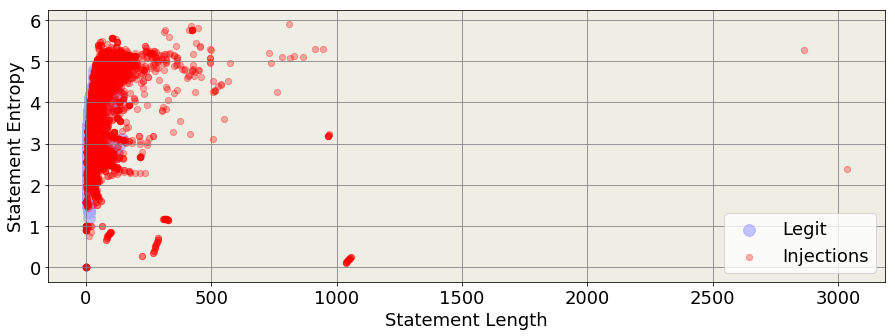

In [15]:

# Split the classes up so we can set colors, size, labels
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEE5'))
ax.grid(color='grey', linestyle='solid')
cond = data['label'] == 'malicious'
evil = data[cond]
legit = data[~cond]
plt.scatter(df_normal['length'], df_normal['entropy'], s=140, c='#aaaaff', label='Legit', alpha=.7)
plt.scatter(df_malicious['length'], df_malicious['entropy'], s=40, c='r', label='Injections', alpha=.3)
plt.legend()
plt.xlabel('Statement Length')
plt.ylabel('Statement Entropy')

## Apply Knn algorithm 
----------
#### KNN algorithm is one of the simplest classification algorithm. Even with such simplicity, it can give highly competitive results. 
    We use KNN because it has three critical perspectives
   * 1. Ease to interpret output

   * 2. Calculation time

   * 3. Predictive Power
##### Reference: https://www.analyticsvidhya.com/blog/2014/10/introduction-k-neighbours-algorithm-clustering/

In [16]:
#Knn algorithm
Y = data['label']
data_modify=data.drop(['label','queries','unicode'],axis=1)
X=data_modify
#X = df_normal(['length','entropy'])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #splitting data
print (len(y_test))

6349


In [18]:
model = KNeighborsClassifier(1)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [19]:
for k in [1,5,15,50,80,100]:
    model = KNeighborsClassifier(k)
    model.fit(X_train, y_train)
    print ("Accuracy with k = %d is %.3f" % (k, metrics.accuracy_score(y_test, model.predict(X_test)))) 

Accuracy with k = 1 is 0.899
Accuracy with k = 5 is 0.924
Accuracy with k = 15 is 0.921
Accuracy with k = 50 is 0.910
Accuracy with k = 80 is 0.906
Accuracy with k = 100 is 0.906


## Apply SVM algorithm 
----------
#### Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. In our case, we used it for classification


In [20]:
#SVM
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 
from sklearn.linear_model import LinearRegression
from scipy import stats
import pylab as pl
from sklearn import svm

seaborn.set()

In [35]:
clf1 = svm.SVC(C=1,kernel='linear',gamma=20,decision_function_shape='ovr')
clf2 = svm.SVC(C=1, kernel='rbf', gamma=20, decision_function_shape='ovr')
#clf3 = svm.SVC(C=1, kernel='poly', degree=3,gamma=20, decision_function_shape='ovr' )
clf3 = svm.SVC(C=1,kernel='sigmoid',gamma=20, decision_function_shape='ovr')
clf4 = svm.LinearSVC(C=1)

In [36]:
clf1=clf1.fit(X_train, y_train)
clf2=clf2.fit(X_train, y_train)
#clf3=clf3.fit(X_train, y_train)

In [37]:
clf3=clf3.fit(X_train, y_train)
#clf4=clf4.fit(X_train, y_train)

In [38]:
 # accuracy
y_hat1 = clf1.predict(X_test)
y_hat2 = clf2.predict(X_test)
y_hat3 = clf3.predict(X_test)
#y_hat4 = clf4.predict(X_test)
print ("Linear accuracy with test dataset is %.3f" % metrics.accuracy_score(y_test, y_hat1))
print ("RBF accuracy with test dataset is %.3f" % metrics.accuracy_score(y_test, y_hat2))
print ("Sigmoid accuracy with test dataset is %.3f" % metrics.accuracy_score(y_test, y_hat3))
#print ("LinearSVC accuracy with test dataset is %.3f" % metrics.accuracy_score(y_test, y_hat4))
#show_accuracy(y_hat, y_test, 'test dataset')

Linear accuracy with test dataset is 0.879
RBF accuracy with test dataset is 0.923
Sigmoid accuracy with test dataset is 0.780


In [32]:
h=0.2
x_min, x_max = X_test['length'].min() - 10, X_test['length'].max() + 10  
y_min, y_max = X_test['entropy'].min() - 1, X_test['entropy'].max() + 1  
xx, yy = np.meshgrid(np.arange(x_min, x_max,h),  
                     np.arange(y_min, y_max,h)) 
answer1 = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
answer2 = clf2.predict(np.c_[xx.ravel(), yy.ravel()])
answer3 = clf3.predict(np.c_[xx.ravel(), yy.ravel()])
#grid_test = np.stack((x1.flat, x2.flat), axis=1)  # test points
#grid_hat = clf1.predict(grid_test)       
#grid_hat = grid_hat.reshape(x1.shape) 
# print 'grid_test = \n', grid_testgrid_hat = clf.predict(grid_test)  

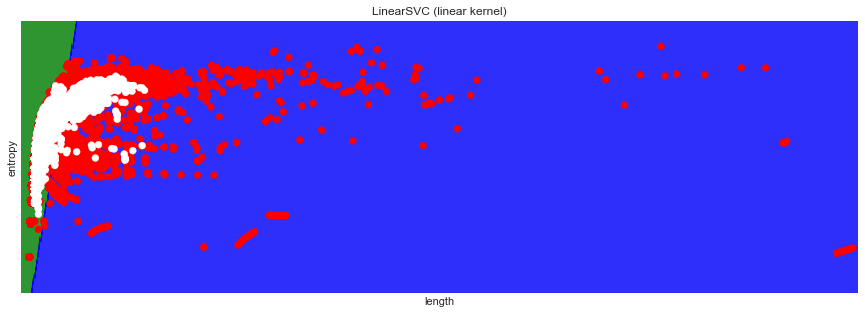

In [34]:
titles = ['LinearSVC (linear kernel)',  
          'SVC with RBF kernel',  
          'SVC with Sigmoid kernel'] 

import matplotlib as mpl
z = answer1.reshape(xx.shape) 
cm_dark1 = mpl.colors.ListedColormap(['w', 'r'])
cm_dark2 = mpl.colors.ListedColormap(['g', 'b'])
plt.contourf(xx, yy, z, cmap=cm_dark2, alpha=0.8)  
plt.scatter(X['length'], X['entropy'], c=Y, cmap=cm_dark1)  
plt.xlabel(u'length')  
plt.ylabel(u'entropy')  
plt.xlim(xx.min(), xx.max())  
plt.ylim(yy.min(), yy.max())  
plt.xticks(())  
plt.yticks(()) 
plt.title(titles[0])  
plt.show()

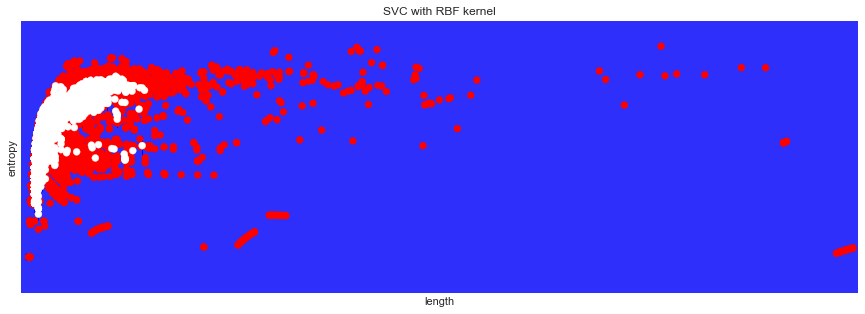

In [47]:
z = answer2.reshape(xx.shape) 
cm_dark1 = mpl.colors.ListedColormap(['w', 'r'])
cm_dark2 = mpl.colors.ListedColormap(['g', 'b'])
plt.contourf(xx, yy, z, cmap=cm_dark2, alpha=0.8)  
plt.scatter(X['length'], X['entropy'], c=Y, cmap=cm_dark1)  
plt.xlabel(u'length')  
plt.ylabel(u'entropy')  
plt.xlim(xx.min(), xx.max())  
plt.ylim(yy.min(), yy.max())  
plt.xticks(())  
plt.yticks(()) 
plt.title(titles[1])  
plt.show()

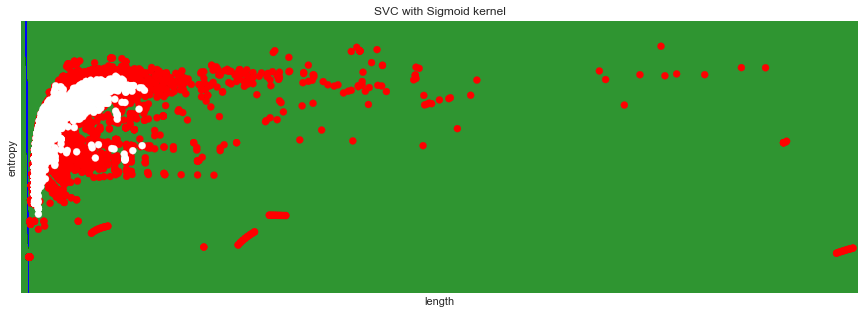

In [48]:
z = answer3.reshape(xx.shape) 
cm_dark1 = mpl.colors.ListedColormap(['w', 'r'])
cm_dark2 = mpl.colors.ListedColormap(['g', 'b'])
plt.contourf(xx, yy, z, cmap=cm_dark2, alpha=0.8)  
plt.scatter(X['length'], X['entropy'], c=Y, cmap=cm_dark1)  
plt.xlabel(u'length')  
plt.ylabel(u'entropy')  
plt.xlim(xx.min(), xx.max())  
plt.ylim(yy.min(), yy.max())  
plt.xticks(())  
plt.yticks(()) 
plt.title(titles[2])  
plt.show()

In [31]:
# may add more feature
#print (data['unicode'])

## Build a logitical regression model using TFIDF over n-grams
-----

In [32]:
def loadFile(name):
    directory = str(os.getcwd())
    filepath = os.path.join(directory, name)
    with open(filepath,'r',encoding="utf-8") as f:
        data = f.readlines()
    data = list(set(data))
    result = []
    for d in data:
        d = str(urllib.parse.unquote(d))   #converting url encoded data to simple string
        result.append(d)
    return result
############################################################
#### Use python script directly for efficency 
############################################################


badQueries = loadFile('malicious.txt')
validQueries = loadFile('normal.txt')

badQueries = list(set(badQueries))
validQueries = list(set(validQueries))


allQueries = badQueries + validQueries
yBad = [1 for i in range(0, len(badQueries))]  #labels, 1 for malicious and 0 for clean
yGood = [0 for i in range(0, len(validQueries))]

y = yBad + yGood #y equals to total labels included bad and good queries



### Lets now use Tfidvectorizer to convert the data into tfidf values and then use our classifier. We are using tfidf values since we want to assign weights to our ngrams e.g the ngram ‘<img’ should have large weight since a query containing this ngram is most likely to be malicious.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split


#transform data into a TFIDF matrix of 1-gram and 2-gram

vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,5)) #converting data to vectors
x = vectorizer.fit_transform(allQueries)

X_transform=x.toarray()
feature_name = vectorizer.get_feature_names()
newDataFrame = pd.DataFrame(X_transform, columns = feature_name)


badCount = len(badQueries)
validCount = len(validQueries)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10) #splitting data
lgs = LogisticRegression(class_weight={1: 2 * validCount / badCount, 0: 1.0}) # class_weight='balanced')




lgs.fit(X_train, y_train) #training our model
print (x.shape)
print(lgs.score(X_test, y_test))

MemoryError: 

In [34]:
predicted = lgs.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, (lgs.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)



NameError: name 'lgs' is not defined

In [ ]:
print("Bad samples: %d" % badCount)
print("Good samples: %d" % validCount)
print("Baseline Constant negative: %.6f" % (validCount / (validCount + badCount)))
print("------------")
print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
print("AUC: %f" % auc)

In [ ]:
from sklearn.metrics import classification_report


